In [1]:
import math
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm 
from scipy.special import comb
import warnings
warnings.filterwarnings("ignore")

np.set_printoptions(suppress=True)
np.set_printoptions(precision=4)

In [2]:
# True quality scores used to generate pairwise comparisons (pwc_mat) and mean opinion scores (mos_mat)
Q_true = np.array([0,0.4084,0.9614,0.9797,0.1016,0.1708,0.1780,0.2378,0.2785]);

# Dataset 1 has four conditions and dataset 2 has five conditions
dataset_sizes = np.array([4,5])

# Matrix with pairwise comparisons: pwc_mat[i,j] is the number of times condition i was selected over j
pwc_mat =np.array ([[0, 0, 0, 3, 0, 3, 0, 0, 0],
                    [6, 0, 0, 0, 0, 6, 0, 0, 5],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [3, 6, 0, 0, 6, 0, 0, 9, 0],
                    [0, 0, 0, 4, 0, 2, 3, 2, 3],
                    [7, 4, 0, 0, 4, 0, 3, 3, 3],
                    [0, 0, 0, 0, 3, 3, 0, 3, 4],
                    [0, 0, 0, 1, 4, 3, 3, 0, 2],
                    [0, 5, 0, 0, 3, 3, 2, 4, 0]])

# Matrix with mean opinion scores - nan valus indicate that conditions were not measured
mos_mat = np.array([[3,4,5,5,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN],
                    [5,7,7,7,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN],
                    [9,7,8,9,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN],
                    [9,9,9,8,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN],
                    [np.NaN, np.NaN,np.NaN,np.NaN,3,2,3,3,2],
                    [np.NaN, np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN],
                    [np.NaN, np.NaN,np.NaN,np.NaN,4,3,3,3,2],
                    [np.NaN, np.NaN,np.NaN,np.NaN,3,3,3,4,2],
                    [np.NaN, np.NaN,np.NaN,np.NaN,3,2,4,4,3]])


In [3]:
def preprocess_data(D, M):
    # Function to prepare the data for optimisation - pre-compute matrices to avoid 
    # repetitive computations in the optimisation
    
    # Number of conditions
    N = D.shape[1]
    
    # non-zero elements in pwc_mat
    nnz_pwc   = (D+D.T)>0
    
    # select non-zero elements from D and D transpose
    D_nnz = D[nnz_pwc]
    DT_nnz = D.T[nnz_pwc]
    Dt = D.T
    D_sum = D+Dt
    
    # Compute N choose K and select only conditions for which pairwise comparisons were collected
    NK = comb(D_sum.T, D)
    NK_nnz = NK[nnz_pwc]
    
    return NK_nnz, DT_nnz, D_nnz, nnz_pwc

In [4]:
def exp_prob(x,D_nnz, DT_nnz, M, nnz_pwc, NK_nnz,sigma_cdf, sigma, N_conds, N_obs,dataset_sizes):
    # Scipy optimise procedure for the mixing of MOS and PWC

    # Extract parameters to optimize
    q = np.zeros(N_conds)
    q[1:N_conds]=x[:(N_conds-1)]
    a = x[(N_conds-1):N_conds+1]
    b = x[N_conds+1:N_conds+3]
    c = x[N_conds+3:]
    
    # Create arrays a,b and c of size N_conds, one element per each quality score
    a_opt = np.empty((0))
    b_opt = np.empty((0))
    c_opt = np.empty((0))
    for ii in range(0,len(dataset_sizes)):
        a_opt = np.concatenate((a_opt,np.ones(dataset_sizes[ii])*a[ii]),axis=0)
        b_opt = np.concatenate((b_opt,np.ones(dataset_sizes[ii])*b[ii]),axis=0)
        c_opt = np.concatenate((c_opt,np.ones(dataset_sizes[ii])*c[ii]),axis=0)

    # Create matrix of probabilities for pairwise comparisons
    xrrsh = np.reshape(np.repeat(q,N_conds, axis = 0),(N_conds,N_conds))
    Pd    = norm.cdf(xrrsh-xrrsh.T,0,sigma_cdf)
    p_pwc = np.multiply(NK_nnz,np.multiply((Pd[nnz_pwc]**D_nnz),(1-Pd[nnz_pwc])**DT_nnz))
    
    
    # Create matrix of probabilities for mean opinion scores
    rep_mat_abc = np.reshape(np.repeat(a_opt*q+b_opt,N_obs, axis = 0),(N_conds,N_obs))
    p_mos = norm.pdf(M, rep_mat_abc , np.transpose(np.tile(np.transpose(abs(a_opt)*c_opt*sigma),(N_obs,1))))
    p_mos[np.isnan(p_mos)]=1.0
    
    # Create prior
    prior = norm.pdf(q, np.mean(q), math.sqrt(N_conds)*sigma)
    
    p_pwc[p_pwc<10**-20] = 10**-20
    p_mos[p_mos<10**-20] = 10**-20
    
    P1 = -np.sum(np.log(p_pwc)) 
    P2 = -np.sum(np.sum(np.log(p_mos)))
    P3 = -np.sum(np.log(prior))
    
    P  = P1+P2+P3
    
    # Make sure that c is greater than 0, required for the p_mos
    if any(c<0):
        P = P*10
    
    return P


In [7]:
def unify_datasets(D,M,dataset_sizes):
    
    # Preprocess the data
    NK_nnz, DT_nnz, D_nnz, nnz_pwc = preprocess_data(pwc_mat,mos_mat)
    
    # create initial parameters
    N_conds = M.shape[0]
    N_obs =  M.shape[1]
    sigma_cdf = 1.4826
    sigma = sigma_cdf/(math.sqrt(2))

    a_array = np.ones(dataset_sizes.shape[0])
    b_array = np.zeros(dataset_sizes.shape[0])
    c_array = np.ones(dataset_sizes.shape[0])

    x0 = np.concatenate((np.zeros(N_conds-1),a_array),axis=0)
    x0 = np.concatenate((x0,b_array),axis=0)
    x0 = np.concatenate((x0,c_array),axis=0)


    t0 = time.time()
    # optimise to find quality scores and parameters a, b and c
    res = minimize(exp_prob, x0,args = (D_nnz, DT_nnz, mos_mat, nnz_pwc, NK_nnz,sigma_cdf, sigma,N_conds,N_obs,dataset_sizes), method='BFGS', options={'maxiter': 100000})
    t1 = time.time()
    total = t1-t0
    
    # Extract individual arrays of parameters
    Q_opt = np.concatenate((np.zeros(1),res.x[0:N_conds-1]), axis=0)
    a = res.x[N_conds-1:N_conds+1]
    b = res.x[N_conds+1:N_conds+3]
    c = res.x[N_conds+3:]

    return Q_opt, a,b,c

In [8]:
# Find quality scores for matrices of pairwise comparisons and mean opinion scores
Q_opt, a,b,c = unify_datasets(D=pwc_mat,M=mos_mat, dataset_sizes=dataset_sizes)

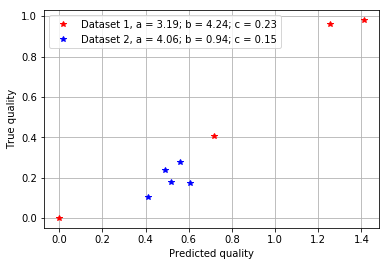

In [9]:
plt.plot(Q_opt[:dataset_sizes[0]], Q_true[:dataset_sizes[0]],'r*')
plt.plot(Q_opt[dataset_sizes[0]:], Q_true[dataset_sizes[0]:],'b*')
plt.xlabel('Predicted quality')
plt.ylabel('True quality')
ds1_legend = 'Dataset 1, a = '+str(round(a[0]*100)/100)+'; b = '+str(round(b[0]*100)/100)+'; c = '+str(round(c[0]*100)/100)
ds2_legend = 'Dataset 2, a = '+str(round(a[1]*100)/100)+'; b = '+str(round(b[1]*100)/100)+'; c = '+str(round(c[1]*100)/100)
plt.legend((ds1_legend, ds2_legend))
plt.grid()
plt.show()